# Import statements; input files; arguments for plots

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import ranksums
from statannotations.Annotator import Annotator
import allel
import random
from IPython.display import FileLink

In [2]:
# input files for clinical study comparison
seq_metadata = pd.read_excel("seq-metadata.xlsx")
rdt_pcr = pd.read_csv("WellResult_qPCRrerun_20221201.csv")
genomes = pd.read_csv('batch132RDTs.tsv',sep='\t') # also for MPHN2
reads = pd.read_csv(r"fastqc_sequence_counts_plot.csv",sep=',')

# input files for MPHN2
MPHN2_pcr = pd.read_csv('2023-01-04 RDTs MPHN2 qPCR.xlsx - Results.csv',skiprows=40)

# input files for synthetic comparisons
elution = pd.read_csv("2022-07-11 145129 excel.xlsx - Elution_time_results.csv")
buffer = pd.read_csv("buffers.csv",skiprows=50)
rotation = pd.read_excel("2023-01-31 143709.xls",skiprows=50)
seeding = pd.read_excel("2023-02-07 repeat degradation.xlsx",skiprows=40)
KFFcomp = pd.read_excel("2023-03-08 Synthetic RDT KFF v Column.xlsx",sheet_name='Results',skiprows=40)

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
args_boxplot = {'boxprops':dict(linestyle='-', linewidth=1.5, color='#00145A',fill=None),
           'flierprops':dict(marker='o', markersize=2.2, linestyle='none'), 
           'whiskerprops':dict(color='#00145A'), 'capprops':dict(color='#00145A'),
           'medianprops':dict(linewidth=1.5, linestyle='-', color='black') , 'width':0.4}

args_stripplot = {'alpha':0.4, 'jitter':0.2, 'size':7, 'hue':"variable", 'palette':['grey']}

args_scatterplot_2x = {'alpha':0.9, 'hue':"variable", 'palette':['grey','black']}

# Functions used across multiple sections

Related to statistics

In [4]:
# function to add in relevant p values for dataframes of style "Cq" where each variable is its own column
def get_pvalues(Cq, pairs):
    # get pvalues for relevant comparisons in pairs
    pvalues = []
    for p in pairs:
        pvalues.append(ranksums(Cq[[p[0]]], Cq[[p[1]]], nan_policy='omit').pvalue[0])
    return pvalues

# function to add in relevant p values for dataframes of "melted" style, with 'variable' and 'value' columns
def get_pvalues2(df, pairs,wilcoxon=False):
    # get pvalues for relevant comparisons in pairs
    pvalues = []
    for p in pairs:
        a,b = df[df.variable==p[0]][['value']], df[df.variable==p[1]][['value']]
        if wilcoxon == True:
            pvalues.append(stats.wilcoxon(a,b).pvalue[0])
        else:
            pvalues.append(ranksums(a,b,nan_policy='omit').pvalue[0]) 
    return pvalues

# give 95% CI for slope
def slope95CI(a,b,text): # compare linear regression between a and b; print text as description
    results = stats.linregress(a,b)
    print(f'Linregress Results for {text}:\nslope = {results.slope:.2f}',\
         f'\nCI = {results.slope-1.96*results.stderr:.2f} to {results.slope+1.96*results.stderr:.2f}',\
         f'\np = {results.pvalue}\n')

To clean up PCR results from ThermoFisher

In [5]:
# take median, unless only one triplicate came back positive (in which case Na)
def nanmedian(series):
    if sum(series.isnull()*1)>1:
        return pd.NA
    else:
        return series.median()
    
# function to take triplicate Ct results from qPCR, and return median for each sample
def PCR_results(df):
    # the columns are named differently depending upon how the file was downloaded from thermofisher
    sample = 'Sample' if 'Sample' in df.columns else 'Sample Name'
    ct = 'Cq' if 'Cq' in df.columns else 'CT'
    
    # set undetermined to nan, then take "nanmedian" (i.e. if 1 triplicate is "positive", treat as negative)
    df[ct] = df[ct].replace('Undetermined', pd.NA)
    aggregation_functions = {sample: 'first', ct: nanmedian}
    df = df.groupby(df[sample]).aggregate(aggregation_functions).reset_index(inplace=False,drop=True)
    
    # set undetermined to 40
    df[ct] = df[ct].replace(pd.NA, 40)
    
    return df

Related to plotting figures

In [6]:
# save figure as...
def save_figure(figname):
    plt.tight_layout()
    plt.savefig(figname)

# Cohort 1: clinical study

## Dataframes

Clean up seq_metadata table

In [7]:
# Two dates were mistyped in the input file -- FIX THIS
seq_metadata.loc[seq_metadata['Test Date']=='2022-08-18','Extraction Date'] = '2022-08-20'
seq_metadata.loc[seq_metadata['Test Date']=='2022-08-15','Extraction Date'] = '2022-08-20'

# set columns: ID number; Diagnosis date
seq_metadata['ID']= seq_metadata['Broad tracking IDs'].squeeze().str.extract(pat = r'(\d+)').iloc[:,0]
seq_metadata.rename(columns={'Enter the date of your positive diagnosis if applicable':'Diagnosis'},inplace=True)

Clean up rdt_value table

In [8]:
# set up with Sample, ID, Cq columns
rdt_value = rdt_pcr.copy()
rdt_value['Sample'] = rdt_value['Sample'].str.replace('strip','str')
rdt_value = PCR_results(rdt_value) # take medians of PCR triplicates
rdt_value['ID'] = [s[0:2] for s in rdt_value['Sample']]

# Exclude samples with Cts in same batch that were higher than the associated control
Ct_04to06 = rdt_value[rdt_value.Sample == '04_05_06_H2O'].Cq.values[0]
Ct_11to14 = rdt_value[rdt_value.Sample == '11_12_13_14_H2O'].Cq.values[0]
for i in range(len(rdt_value)):
    if (rdt_value.ID[i] in ['04','05','06']) and (rdt_value.Cq[i] > Ct_04to06) and (rdt_value.Cq[i] < 40):
        rdt_value.loc[i,'Cq'] = np.nan
    if (rdt_value.ID[i] in ['11','12','13','14']) and (rdt_value.Cq[i] > Ct_11to14) and (rdt_value.Cq[i] < 40):
        rdt_value.loc[i,'Cq'] = np.nan
rdt_value.dropna(subset=['Cq'],inplace=True)

# Exclude fully negative individuals, and additional samples that were part of PCR test but not part of study
rdt_value = rdt_value[rdt_value['Sample'].squeeze().str.contains(pat='^15|02|03|P_')== False]

# Exclude non-clinical samples (i.e. PCR standards, water controls)
rdt_value = rdt_value[rdt_value['Sample'].str.match(pat='^([0]?[1-9]|1[0-6])\_[RBQi]')].reset_index(drop=True)
rdt_value['ID'] = [s[0:2] for s in rdt_value.Sample]

# Categorize test type
rdt_value['variable'] = np.nan
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='Q.*_str'))[0], 'variable'] = 'Quickvue Strip'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='B.*_str'))[0], 'variable'] = 'Binax Strip'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='_iH'))[0], 'variable'] = 'iHealth'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='_R'))[0], 'variable'] = 'PCR Swab'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='Q.*_tube'))[0], 'variable'] = 'Quickvue Tube'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='B.*_swab'))[0], 'variable'] = 'Binax Swab'

Compare group order (data frame: df_order) *and* collect each strip's difference from R (data frame: df_total_Cq)

In [9]:
first, second = [], [] # to store first & second test Ct
iH, B, Q = [], [], [] # to store each strip's difference from R

for ID in rdt_value.ID.unique():
    # pull out RDT order from metadata
    order = seq_metadata.Group[seq_metadata.ID==ID].values[0][3:].split(',')
    # compare group order for all positive individuals who took 2 rapid tests & PCR swab
    if sum(rdt_value[rdt_value.ID==ID].Sample.str.contains('r|R|i'))==3:
        first.append(rdt_value[rdt_value['Sample'].str.fullmatch(pat=ID+'_'+order[0]+'[^w]*')==True].Cq.values[0])
        second.append(rdt_value[rdt_value['Sample'].str.fullmatch(pat=ID+'_'+order[1]+'[^w]*')==True].Cq.values[0])
    # look at difference of each strip from R
    strips = rdt_value[rdt_value['Sample'].str.match(pat=ID+'.*(str|iH)')==True].reset_index()
    R = rdt_value[rdt_value['Sample'].str.match(pat=ID+'.*R')==True].Cq.values[0]
    for i in range(len(strips)):
        if 'iH' in strips.Sample[i]:
            iH.append(strips.Cq[i] - R)
        elif 'B' in strips.Sample[i]:
            B.append(strips.Cq[i] - R)
        else:
            Q.append(strips.Cq[i] - R)
        
df_order = pd.DataFrame({'First':first,'Second':second}).melt()
df_total_Cq = pd.DataFrame.from_dict({'iHealth':iH,'Binax':B,'Quickvue':Q,'All':iH+B+Q}, orient='index').T

Create file that combines Ct data with metadata re: diagnosis, test, & extraction dates, merging by ID

In [10]:
dates = pd.merge(seq_metadata,rdt_value,how='right',on='ID')
dates = dates[['Diagnosis','Test Date','Extraction Date','ID','Sample','Cq']]

# add in date differences for diagnosis to test, test to extraction; & Ct minus Ct of corresponding PCR Swab
dates['Days_Diagnosis_Test']  = [d.days for d in (dates['Test Date'] - dates['Diagnosis'])]
dates['Days_Test_Extraction'] = [d. days for d in (dates['Extraction Date'] - dates['Test Date'])]
dates['R_diff'] = [(dates.Cq[i]-dates[dates.Sample==(dates.ID[i]+'_R')].Cq).values[0] for i in range(len(dates))]

# change "variable" to be larger categorical groups (i.e. RDT v. PCR, swab v. strip v. tube)
dates['variable'] = [s.split('_')[-1] for s in dates.Sample]
dates.variable = dates.variable.replace({'str':'Strip','iH':'Strip','R':'Polypropylene Swab'})

Clean up genomic data frame, and merge with other data frames

In [11]:
genome_data_1 = genomes.rename(columns={"entity:batch132RDTs_id": "Sample"}).copy()
genome_data_1['Sample'] = [item[0].replace('strip','str') for item in genome_data_1['Sample'].str.split('.')]

# merge with other dataframes to add in Cts & total reads
total_reads = reads.copy()
total_reads['Category'] = pd.Series([i[-1].split('.')[0][1:].replace('strip','str') for i \
                           in total_reads['Category'].str.split('|')])
genome_data_1 = pd.merge(genome_data_1, total_reads.rename(columns={'Category':'Sample'}), how='right', on='Sample')
genome_data_1 = pd.merge(genome_data_1, rdt_value, how='right', on='Sample')

# set negative samples (i.e., Ct=40) to have a genome length of 0
genome_data_1.loc[np.where(genome_data_1.Cq==40)[0],'assembly_length_unambiguous'] = np.nan

# drop any genomes that are discarded due to being shorter than associated batch extraction control
limit04_06 = genomes[genomes['entity:batch132RDTs_id']=='04_05_06_H2O'].assembly_length_unambiguous.values[0]
limit11_14 = genomes[genomes['entity:batch132RDTs_id']=='11_12_13_14_H2O'].assembly_length_unambiguous.values[0]
for i in range(len(genome_data_1)):
    if genome_data_1.ID[i] in ['04','05','06']:
        if genome_data_1.assembly_length_unambiguous[i] < limit04_06:
            for column in genomes.columns[1:]:
                genome_data_1.loc[i,column] = np.nan
    elif genome_data_1.ID[i] in ['11','12','13','14']:
        if genome_data_1.assembly_length_unambiguous[i] < limit11_14:
            for column in genomes.columns[1:]:
                genome_data_1.loc[i,column] = np.nan
genome_data_1 = genome_data_1.dropna(subset=['assembly_length_unambiguous']).reset_index(drop=True)
                
# add column for % of genome assembled
LENGTH = 29903
genome_data_1['Percent'] = genome_data_1['assembly_length_unambiguous']/LENGTH

# Strip, PCR Swab, or other
genome_data_1['category'] = np.nan
genome_data_1.loc[genome_data_1.variable=='PCR Swab','category'] = 'Polypropylene Swab'
for strip in ['Quickvue Strip','Binax Strip','iHealth']:
    genome_data_1.loc[genome_data_1.variable==strip,'category'] = 'Strip'

## Box & whisker plots - Ct

In [12]:
sns.set_style("white")  # "white","dark","darkgrid","ticks"

Mean of all strips' difference: 10.15989620995116 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

iHealth vs. Binax: Custom statistical test, P_val:6.374e-01
Binax vs. Quickvue: Custom statistical test, P_val:9.219e-02
iHealth vs. Quickvue: Custom statistical test, P_val:2.200e-01


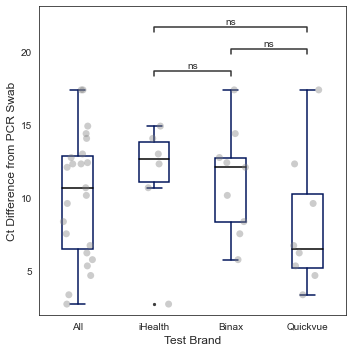

In [13]:
plt.figure(figsize=[5,5])

order = ['All','iHealth','Binax','Quickvue']
ax = sns.boxplot(x="variable", y="value", order=order,data=pd.melt(df_total_Cq[order]), **args_boxplot)
sns.stripplot(data=pd.melt(df_total_Cq[order]), x="variable", y="value", **args_stripplot)

print('Mean of all strips\' difference:', df_total_Cq.All.mean(),'\n')

pairs = [['iHealth','Binax'],['iHealth','Quickvue'],['Binax','Quickvue']]
annotator = Annotator(ax, pairs,data=pd.melt(df_total_Cq),x='variable',y='value',order=order)
annotator.set_pvalues(get_pvalues(df_total_Cq,pairs))
annotator.annotate()

plt.xlabel("Test Brand", fontweight='normal', fontsize=12)
plt.ylabel("Ct Difference from PCR Swab", fontweight='normal', fontsize=12) 
plt.yticks(np.arange(5,25,5))
ax.get_legend().remove();
save_figure('fig/CT_difference_from_PCR.svg')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

First vs. Second: Custom statistical test, P_val:6.936e-01


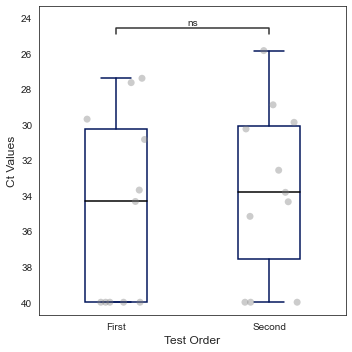

In [14]:
plt.figure(figsize=[5,5])

ax = sns.boxplot(x="variable", y="value", data=df_order,**args_boxplot)
sns.stripplot(data=df_order, x="variable", y="value",**args_stripplot)

ax.invert_yaxis()

pairs = df_order.variable.unique()
annotator = Annotator(ax, [pairs],data=df_order,x='variable',y='value')
annotator.set_pvalues([ranksums(first,second,nan_policy='omit').pvalue])
annotator.annotate()

plt.xlabel("Test Order", fontweight='normal', fontsize=12)
plt.ylabel("Ct Values", fontweight='normal', fontsize=12) 
plt.legend([],[], frameon=False)

save_figure('fig/CT_test_order.svg')

##  Statistics for genome comparisons

In [15]:
# return relevant statistics in terms of how many samples had Cts, complete genomes, etc

# update dataframes with columns that will enable groupby() analyses
rdt_value['Ct<40'] = [g<40 for g in rdt_value.Cq]
genome_data_1['Ct<40'] = [g<40 for g in genome_data_1.Cq]
genomes_no40 = genome_data_1[genome_data_1['Ct<40']]
genomes_no40['Percent>80'] = [g>.8 for g in genomes_no40.Percent]
genomes_no40['Percent>10'] = [g>.10 for g in genomes_no40.Percent]

# calculate the various stats we want
genome_stats = pd.DataFrame({# Number & percent of samples with viral material, & total samples
                            'NumberPositive':rdt_value.groupby('variable').sum()['Ct<40'],\
                            'NumberSamples':rdt_value.groupby('variable').count()['Cq'],\
                            # Ct range of positive samples, and mean
                            'MinCt':rdt_value.groupby('variable').min()['Cq'],\
                            'MaxCt':rdt_value[rdt_value.Cq<40].groupby('variable').max()['Cq'],\
                            'MeanCt':rdt_value[rdt_value.Cq<40].groupby('variable').mean()['Cq'],\
                            # Number of sequenced samples; number & percent of samples with complete genomes
                            'NumberSequenced':genomes_no40.groupby('variable').count()['Cq'],\
                            'NumberComplete':genomes_no40.groupby('variable').sum()['Percent>80'],\
                            'PercentComplete':genomes_no40.groupby('variable').mean()['Percent>80'],\
                            'NumPartial':genomes_no40.groupby('variable').sum()['Percent>10'],\
                            # Average percent of genome covered, for positive samples
                            'AveragePercent':genomes_no40.groupby('variable').mean()['Percent']})
genome_stats['PercentWithCt'] = genome_stats['NumberPositive'] / genome_stats['NumberSamples'] * 100
# update any percent stats to be from 0-100 instead of 0-1
for percent in ['PercentComplete','AveragePercent']:
    genome_stats[percent] = (genome_stats[percent]*100)
# round all numbers to have only one decimal point
genome_stats = genome_stats.round(decimals=1)

In [16]:
genome_stats

,NumberPositive,NumberSamples,MinCt,MaxCt,MeanCt,NumberSequenced,NumberComplete,PercentComplete,NumPartial,AveragePercent,PercentWithCt
variable,,,,,,,,,,,
Binax Strip,5,9,27.6,33.8,30.3,2,0,0.0,1,24.4,55.6
Binax Swab,8,9,19.5,33.0,26.0,8,3,37.5,7,69.8,88.9
PCR Swab,13,13,17.8,31.7,23.7,13,13,100.0,13,98.0,100.0
Quickvue Strip,6,8,25.8,35.2,29.6,5,2,40.0,4,68.0,75.0
Quickvue Tube,2,6,31.2,33.3,32.2,1,1,100.0,1,95.5,33.3
iHealth,5,6,30.8,34.3,33.2,3,0,0.0,2,46.4,83.3


In [17]:
# for which samples could clade/lineage be accurately predicted by RDTs without PCR swab?
lineages = pd.DataFrame(index=genomes_no40.ID.unique(), \
                        columns=['R_clade','R_pango','Str_clade','Str_pango','Clade','Pango'])
for i in lineages.index:
    lineages['R_clade'].loc[i] = genomes_no40[genomes_no40.Sample==(i+"_R")].nextclade_clade.values[0]
    lineages['R_pango'].loc[i] = genomes_no40[genomes_no40.Sample==(i+"_R")].pango_lineage.values[0]
    lineages['Str_clade'].loc[i] = genomes_no40[genomes_no40.Sample.str.contains(pat=i+'_.*[^R]')].nextclade_clade.values
    lineages['Str_pango'].loc[i] = genomes_no40[genomes_no40.Sample.str.contains(pat=i+'_.*[^R]')].pango_lineage.values
    lineages['Clade'].loc[i] = lineages.R_clade[i] in lineages.Str_clade[i] 
    lineages['Pango'].loc[i] = lineages.R_pango[i] in lineages.Str_pango[i] 

display(lineages)
print(lineages[['Clade','Pango']].sum())
print(lineages[['Clade','Pango']].sum()/13)

,R_clade,R_pango,Str_clade,Str_pango,Clade,Pango
01,22B (Omicron),BA.5.2.1,"[22B (Omicron), 22B (Omicron)]","[Unassigned, Unassigned]",True,False
04,22D (Omicron),BA.2.75.2,[22D (Omicron)],[BA.2.75.2],True,True
05,22B (Omicron),BF.21,[],[],False,False
06,22B (Omicron),BF.27,[22B (Omicron)],[BF.27],True,True
07,22B (Omicron),BA.5.2.1,"[22B (Omicron), recombinant]","[BA.5.2.1, Unassigned]",True,True
08,22A (Omicron),BA.4.6,[22A (Omicron)],[BA.4.6],True,True
09,22B (Omicron),BA.5.2,"[nan, recombinant, recombinant]","[nan, Unassigned, Unassigned]",False,False
10,22B (Omicron),BE.1.1,"[22B (Omicron), 22B (Omicron), 22B (Omicron)]","[Unassigned, BE.1.1, Unassigned]",True,True
11,22B (Omicron),BE.1.1,[],[],False,False
12,22B (Omicron),BF.26,[22B (Omicron)],[BF.26],True,True


Clade    10
Pango     8
dtype: object
Clade    0.769231
Pango    0.615385
dtype: object


In [18]:
# Above analysis but for each individual strip
df = genomes_no40.set_index(genomes_no40.Sample)

for pattern in ['_iH','Q.*_str','Q.*_tube','B.*_str', 'B.*_swab']:
    strip = df[df.Sample.str.contains(pat=pattern)].Sample.values
    swab = [i[0:2]+"_R" for i in strip]
    df.loc[[s for s in df.Sample if (s in strip) or (s in swab)]][['nextclade_clade', 'pango_lineage']]
    df1 = df.loc[[s for s in df.Sample if s in strip]][['nextclade_clade', 'pango_lineage']].reset_index(drop=True)
    df2 = df.loc[[s for s in df.Sample if s in swab]][['nextclade_clade', 'pango_lineage']].reset_index(drop=True)
    print(pattern, '\n', (df1 == df2).sum(),'total:',len(df1),'\n')

_iH 
 nextclade_clade    2
pango_lineage      0
dtype: int64 total: 3 

Q.*_str 
 nextclade_clade    4
pango_lineage      3
dtype: int64 total: 5 

Q.*_tube 
 nextclade_clade    1
pango_lineage      1
dtype: int64 total: 1 

B.*_str 
 nextclade_clade    1
pango_lineage      0
dtype: int64 total: 2 

B.*_swab 
 nextclade_clade    7
pango_lineage      5
dtype: int64 total: 8 



In [19]:
# Above analysis for iHealth strip only
lineages = pd.DataFrame(index=genomes_no40.ID.unique(), \
                        columns=['R_clade','R_pango','Str_clade','Str_pango','Clade','Pango'])
for i in lineages.index:
    lineages['R_clade'].loc[i] = genomes_no40[genomes_no40.Sample==(i+"_R")].nextclade_clade.values[0]
    lineages['R_pango'].loc[i] = genomes_no40[genomes_no40.Sample==(i+"_R")].pango_lineage.values[0]
    lineages['Str_clade'].loc[i] = genomes_no40[genomes_no40.Sample.str.contains(pat=i+'_.*[^R]')].nextclade_clade.values
    lineages['Str_pango'].loc[i] = genomes_no40[genomes_no40.Sample.str.contains(pat=i+'_.*[^R]')].pango_lineage.values
    lineages['Clade'].loc[i] = lineages.R_clade[i] in lineages.Str_clade[i] 
    lineages['Pango'].loc[i] = lineages.R_pango[i] in lineages.Str_pango[i] 

display(lineages)
print(lineages[['Clade','Pango']].sum())
print(lineages[['Clade','Pango']].sum()/13)

,R_clade,R_pango,Str_clade,Str_pango,Clade,Pango
01,22B (Omicron),BA.5.2.1,"[22B (Omicron), 22B (Omicron)]","[Unassigned, Unassigned]",True,False
04,22D (Omicron),BA.2.75.2,[22D (Omicron)],[BA.2.75.2],True,True
05,22B (Omicron),BF.21,[],[],False,False
06,22B (Omicron),BF.27,[22B (Omicron)],[BF.27],True,True
07,22B (Omicron),BA.5.2.1,"[22B (Omicron), recombinant]","[BA.5.2.1, Unassigned]",True,True
08,22A (Omicron),BA.4.6,[22A (Omicron)],[BA.4.6],True,True
09,22B (Omicron),BA.5.2,"[nan, recombinant, recombinant]","[nan, Unassigned, Unassigned]",False,False
10,22B (Omicron),BE.1.1,"[22B (Omicron), 22B (Omicron), 22B (Omicron)]","[Unassigned, BE.1.1, Unassigned]",True,True
11,22B (Omicron),BE.1.1,[],[],False,False
12,22B (Omicron),BF.26,[22B (Omicron)],[BF.26],True,True


Clade    10
Pango     8
dtype: object
Clade    0.769231
Pango    0.615385
dtype: object


## Gender and age distributions

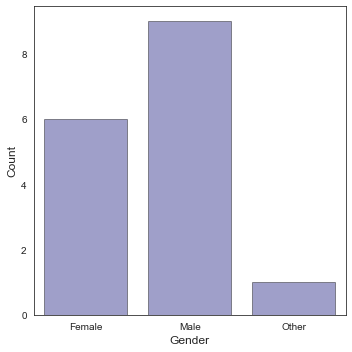

In [20]:
## Gender and age demographics
plt.figure(figsize=[5,5])

sns.set_style("white") 
gender_dist = sns.countplot(x=seq_metadata['What is your gender?'],color='darkblue', alpha=0.4,edgecolor='black')

plt.xlabel("Gender", fontweight='normal', fontsize=12)
plt.ylabel("Count", fontweight='normal', fontsize=12)

save_figure('fig/cohort1_gender.svg')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


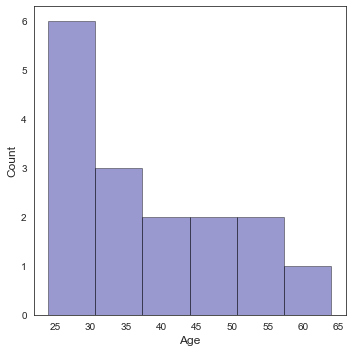

In [21]:
plt.figure(figsize=[5,5])

age_dist = sns.distplot(x=seq_metadata['What is your age in years?'], hist=True, kde=False, 
             bins=int(30/5), color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Age", fontweight='normal', fontsize=12)
plt.ylabel("Count", fontweight='normal', fontsize=12)

save_figure('fig/cohort1_age.svg')

## iSNV analyses comparing RDTs and PCRs

In [22]:
# return a dataframe for an individual vcf file
# quality control: 
# 1: at least 2F and 2R reads for SNV
# 2: AF at least 3%
# 3: fisher test for F v. R & iSNV v ref > .01 (corresponds to roughly SB=20 cutoff)
def cleaned_vcf(filename, iSNV=False):
    df = allel.vcf_to_dataframe(filename, fields=['POS','ID','REF','ALT','QUAL','DP','AF','DP4','SB'])
    if df is None:
        return df
    
    df = df[(df.DP4_3>=2)*1 + (df.DP4_4>=2)*1 == 2]
    df = df[df.AF_1>=.03]
    df = df[[stats.fisher_exact([[df.DP4_1[i],df.DP4_2[i]],[df.DP4_3[i],df.DP4_4[i]]]).pvalue>.01 for i in df.index]]

    # iSNVs only
    if iSNV:
        df = df[df.AF_1<0.5]
    
    return df.reset_index(drop=True)

# return a dataframe for an individual coverage plot (txt file)
# only return locations with DP>10 (or other value entered into function)
def cleaned_cov(filename, DP=10):
    df = pd.read_csv(filename, sep='\t', header=None, names=['Ref','POS','DP'])
    return df[df.DP>=DP].reset_index(drop=True)

def return_SNVs(df, iSNV=False, consensus=False):
    if iSNV == True:
        return set([df.REF[i]+str(df.POS[i])+df.ALT_1[i] for i in df.index if df.AF_1[i]<0.5])
    elif consensus == True:
        return set([df.REF[i]+str(df.POS[i])+df.ALT_1[i] for i in df.index if df.AF_1[i]>=0.5])
    else:
        return set([df.REF[i]+str(df.POS[i])+df.ALT_1[i] for i in df.index])
    
# function that takes the number of samples (i.e. SNVs not shared), & percentage of them with given value
# (i.e. how many SNVs were from RDT only), and returns p value for whether this is from equally distributed pop
# double-sided test
def permutation_from_50(n,p,seed=0):
    random.seed(seed)
    percentages = [np.array(random.choices([0,1],k=n)).mean() for i in range(int(1e5))]
    return np.mean(np.abs(np.array(percentages)-.5)>np.abs(p-.5))

In [23]:
# curate all vcf files, all coverage_plot.txt files (dataframe with filename, Sample name, patient ID)
vcf_files, cov_files = pd.DataFrame(), pd.DataFrame()
vcf_files['filename'] = !ls ../vcf/*.vcf
cov_files['filename'] = !ls ../covplot/*.txt

for i, df in enumerate([vcf_files, cov_files]): # add in columns for Sample name & patient ID
    df['Sample'] = [i[2].split('.')[0].replace('strip','str') for i in df.filename.str.split('/')]
    df['ID'] = [s[0:2] for s in df.Sample]
    
# limit to files that were actually sequenced, and that have more than one sample per individual; cohort #1 only
vcf_files = vcf_files[[s in list(genome_data_1[genome_data_1.Percent>0].Sample) for s in vcf_files.Sample]]
cov_files = cov_files[[s in list(genome_data_1[genome_data_1.Percent>0].Sample) for s in cov_files.Sample]]
vcf_files = vcf_files[[ID not in vcf_files.ID.unique()[vcf_files.groupby('ID').count()['Sample']==1] \
         for ID in vcf_files.ID]].reset_index(drop=True)
cov_files = cov_files[[ID not in cov_files.ID.unique()[cov_files.groupby('ID').count()['Sample']==1] \
         for ID in cov_files.ID]].reset_index(drop=True)

# let's store in a dataframe:
# Number of: consensus SNVs in both samples, separately & together
# Number of: iSNVs in both samples, separately & together
# Number of: consensus SNVs & iSNVs that are seen in only one sample
df_comparisons = pd.DataFrame(columns=['R','other',\
                                       'SNV_R','SNV_o',\
                                       'iSNV_R','iSNV_o',\
                                       'SNV_not_shared','iSNV_not_shared',\
                                       'SNV_all','iSNV_all'])

# let's store in dataframe:
# relevant information for any (i)SNVs present in PCR but not RDT, or RDT but not PCR
# and also all SNVs
merged_notshared = pd.DataFrame()
merged_all = pd.DataFrame()

# take samples from same individual, R v. each other sample pairwise
for R in vcf_files.filename[vcf_files.filename.str.contains('_R')]:
    i = np.where(vcf_files.filename==R)[0][0]
    others_vcf = vcf_files[(vcf_files.ID==vcf_files.ID[i]) & (vcf_files.filename!=R)]
    others_cov = cov_files[(cov_files.ID==cov_files.ID[i]) & (cov_files.index!=i)]    
    for o in range(len(others_cov)): # to actually compare R to each other sample pairwise
        # use coverage_plot.txt to select only regions of shared coverage (depth >= 10)
        cov1 = cleaned_cov(cov_files[cov_files.Sample==cov_files.Sample[i]].filename.values[0], DP=100)
        cov2 = cleaned_cov(others_cov.filename.values[o], DP=100)
        shared = set(cov1.POS) & set(cov2.POS)
        
        # get cleaned_vcf dataframes for both samples being compared; limit both to shared positions
        vcf1 = cleaned_vcf(vcf_files[vcf_files.Sample==vcf_files.Sample[i]].filename.values[0])
        vcf2 = cleaned_vcf(others_vcf.filename.values[o])
        if vcf1 is not None and vcf2 is not None:
            vcf1 = vcf1[vcf1.POS.isin(shared)].reset_index(drop=True)
            vcf2 = vcf2[vcf2.POS.isin(shared)].reset_index(drop=True)

            # get SNVs for both limited dataframes; compare the two sets
            a = return_SNVs(vcf1, consensus=True) # PCR consensus level
            A = return_SNVs(vcf2, consensus=True) # RDT consensus level
            b = return_SNVs(vcf1, iSNV=True)      # PCR iSNV
            B = return_SNVs(vcf2, iSNV=True)      # RDT iSNV
            if len(a) > 0 and len(A) > 0:
                row = [vcf_files.Sample[i], others_cov.Sample.values[o],
                       len(a), len(A), len(b), len(B), 
                       len((a-(A|B)) | (A-(a|b))), len((b-(A|B)) | (B-(a|b))),
                       len(a|A), len(b|B)]
                df_comparisons.loc[len(df_comparisons.index)] = row
            
            # combine vcfs, and add SNVs that weren't shared to a master VCF file
            tmp = vcf1[['POS','ALT_1','DP','AF_1']].merge(vcf2[['POS','ALT_1','DP','AF_1']],\
                                                          how='outer',on=['POS'])
            tmp['Sample'] = others_cov.Sample.values[0] # add in sample name for non-PCR sample
            tmp.DP_x = [cov1[cov1.POS==x].DP.values[0] for x in tmp.POS] # fill in DP for nans
            tmp.DP_y = [cov2[cov2.POS==x].DP.values[0] for x in tmp.POS]
            merged_notshared = merged_notshared.append(tmp[tmp.isna().any(axis=1)])
            merged_all = merged_all.append(tmp)

# add additional columns to dataframe
df_comparisons[df_comparisons.columns[2:]] = df_comparisons[df_comparisons.columns[2:]].astype('Int64')
df_comparisons['%notshared_SNV'] = df_comparisons['SNV_not_shared']/df_comparisons['SNV_all']*100
df_comparisons['%notshared_iSNV'] = df_comparisons['iSNV_not_shared']/df_comparisons['iSNV_all']*100
df_comparisons[df_comparisons.columns[-2:]] = df_comparisons[df_comparisons.columns[-2:]].round(1)

In [24]:
df_comparisons

,R,other,SNV_R,SNV_o,iSNV_R,iSNV_o,SNV_not_shared,iSNV_not_shared,SNV_all,iSNV_all,%notshared_SNV,%notshared_iSNV
0,01_R,01_B1_swab,18,18,2,0,2,2,19,2,10.5,100.0
1,01_R,01_Q2_str,21,27,1,3,6,4,27,4,22.2,100.0
2,04_R,04_B2_swab,24,23,2,4,0,5,24,6,0.0,83.3
3,06_R,06_Q2_tube,31,35,1,11,4,10,35,11,11.4,90.9
4,07_R,07_B2_swab,38,39,9,10,1,17,39,18,2.6,94.4
5,07_R,07_Q1_str,1,1,0,0,0,0,1,0,0.0,NaN
6,08_R,08_B2_swab,33,32,2,5,7,7,36,7,19.4,100.0
7,09_R,09_iH,3,3,0,0,0,0,3,0,0.0,NaN
8,10_R,10_B1_str,27,29,0,0,4,0,30,0,13.3,NaN
9,10_R,10_B2_swab,63,65,0,2,4,2,66,2,6.1,100.0


In [25]:
def print_relevant_info(df_comp, merged_NS):
    tmp1 = df_comp.sum()
    print('# of SNVs not seen in other:', tmp1.SNV_not_shared)
    print('# of iSNVs not seen in other:', tmp1.iSNV_not_shared)
    print('% of SNVs not seen in other:', tmp1.SNV_not_shared/tmp1.SNV_all)
    print('% of iSNVs not seen in other:', tmp1.iSNV_not_shared/tmp1.iSNV_all)
    tmp2 = merged_NS[(merged_NS.AF_1_x>=.05) | (merged_NS.AF_1_y>=0.5)].isna().sum()
    print('% of SNVs not seen, which were in RDT:', tmp2.ALT_1_x / (tmp2.ALT_1_x+tmp2.ALT_1_y))
    print('p value for this:', permutation_from_50(tmp1.SNV_not_shared, tmp2.ALT_1_x / (tmp2.ALT_1_x+tmp2.ALT_1_y)))
    tmp3 = merged_NS[(merged_NS.AF_1_x<.05) | (merged_NS.AF_1_y<0.5)].isna().sum()
    print('% of iSNVs not seen, which were in RDT:', tmp3.ALT_1_x / (tmp3.ALT_1_x+tmp3.ALT_1_y))
    print('p value for this:', permutation_from_50(tmp1.iSNV_not_shared, tmp3.ALT_1_x / (tmp3.ALT_1_x+tmp3.ALT_1_y)))

In [26]:
print('FOR ALL:')
print_relevant_info(df_comparisons, merged_notshared)

print('\nFOR SWABS ONLY:')
df_comp = df_comparisons[df_comparisons.other.str.contains('swab')]
merged_NS = merged_notshared[merged_notshared.Sample.str.contains('swab')]
print_relevant_info(df_comp, merged_NS)

print('\nFOR STRIPS ONLY:')
df_comp = df_comparisons[df_comparisons.other.str.contains('str') | df_comparisons.other.str.contains('iH')]
merged_NS = merged_notshared[merged_notshared.Sample.str.contains('str') | merged_notshared.Sample.str.contains('iH')]
print_relevant_info(df_comp, merged_NS)

FOR ALL:
# of SNVs not seen in other: 54
# of iSNVs not seen in other: 105
% of SNVs not seen in other: 0.0944055944055944
% of iSNVs not seen in other: 0.9722222222222222
% of SNVs not seen, which were in RDT: 0.6
p value for this: 0.1344
% of iSNVs not seen, which were in RDT: 0.851063829787234
p value for this: 0.0

FOR SWABS ONLY:
# of SNVs not seen in other: 19
# of iSNVs not seen in other: 53
% of SNVs not seen in other: 0.07539682539682539
% of iSNVs not seen in other: 0.9636363636363636
% of SNVs not seen, which were in RDT: 0.5405405405405406
p value for this: 0.64822
% of iSNVs not seen, which were in RDT: 0.8208955223880597
p value for this: 0.0

FOR STRIPS ONLY:
# of SNVs not seen in other: 31
# of iSNVs not seen in other: 42
% of SNVs not seen in other: 0.10877192982456141
% of iSNVs not seen in other: 1.0
% of SNVs not seen, which were in RDT: 0.625
p value for this: 0.15169
% of iSNVs not seen, which were in RDT: 0.8823529411764706
p value for this: 0.0


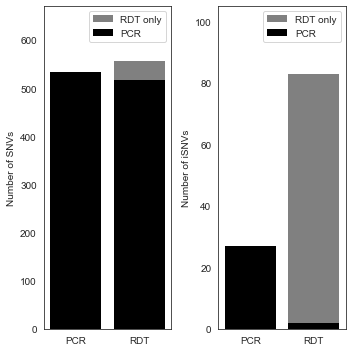

In [27]:
#1x2 plot, comparing pcr to rdt; for either SNV or iSNV
f, ax = plt.subplots(1,2, figsize=[5,5])

# define function that will return numbers we need for barplot
def return_relevant_numbers(df,iSNV=False):
    if iSNV==False:
        n_PCR = sum(df.AF_1_x>=0.5)
        n_RDTandPCR = sum((df.AF_1_y>=0.5) & (df.AF_1_x>=0.5))
        n_RDT = sum(df.AF_1_y>=0.5)
    elif iSNV==True:
        n_PCR = sum(df.AF_1_x<0.5)
        n_RDTandPCR = sum((df.AF_1_y<0.5) & (df.AF_1_x<0.5))
        n_RDT = sum(df.AF_1_y<0.5)
    return([n_PCR, n_RDTandPCR, n_RDT])

# define function that will plot
def return_relevant_plot(results, rdt_type, ax, iSNV=False):
    data = pd.DataFrame({'type':['PCR',rdt_type],'bottom':[results[0],results[1]],'top':[0,results[2]]})
    sns.barplot(ax=ax,data=data,x='type',y='top',color='gray',label='RDT only', linewidth=0)
    sns.barplot(ax=ax,data=data,x='type',y='bottom',color='black',label='PCR', linewidth=0)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Number of '+'i'*iSNV+'SNVs')
    if iSNV:
        ax.set_ylim([0,105])
    else:
        ax.set_ylim([0,470])

# SNV v. iSNV
return_relevant_plot(return_relevant_numbers(merged_all), 'RDT', ax[0])
ax[0].set_ylim([0,670])
return_relevant_plot(return_relevant_numbers(merged_all, iSNV=True), 'RDT', ax[1], iSNV=True)

save_figure('fig/genomic_SNVs_iSNVs.svg')

In [28]:
# fisher's test with 2x2 table of rdt swab vs rdt strip and concordant SNVs (number not %) vs discordant SNVs
df_swab  = merged_all[merged_all.Sample.str.contains('swab') & \
                      ((merged_all.AF_1_x>=0.5) | (merged_all.AF_1_y>=0.5))]
df_strip = merged_all[(merged_all.Sample.str.contains('str') | merged_all.Sample.str.contains('iH')) & \
                      ((merged_all.AF_1_x>=0.5) | (merged_all.AF_1_y>=0.5))]

def relevant_fisher_test(df_swab, df_strip):
    swab_disc  = df_swab.isna().ALT_1_x.sum()  + df_swab.isna().ALT_1_y.sum()
    strip_disc = df_strip.isna().ALT_1_x.sum() + df_strip.isna().ALT_1_y.sum()

    test = [[len(df_swab)-swab_disc,   swab_disc], \
            [len(df_strip)-strip_disc, strip_disc]]
    print(test)
    print(stats.fisher_exact(test))

print('Fisher for consensus-level SNVs, RDT strip v. RDT swab:')
relevant_fisher_test(df_swab, df_strip)

# fisher's test with 2x2 table of rdt swab vs rdt strip and concordant iSNVs (number not %) vs discordant iSNVs
df_swab  = merged_all[merged_all.Sample.str.contains('swab') & \
                      ((merged_all.AF_1_x<0.5) | (merged_all.AF_1_y<0.5))]
df_strip = merged_all[(merged_all.Sample.str.contains('str') | merged_all.Sample.str.contains('iH')) & \
                      ((merged_all.AF_1_x<0.5) | (merged_all.AF_1_y<0.5))]

print('\nFisher for iSNVs, RDT strip v. RDT swab:')
relevant_fisher_test(df_swab, df_strip)

Fisher for consensus-level SNVs, RDT strip v. RDT swab:
[[290, 31], [197, 19]]
SignificanceResult(statistic=0.9022433273292942, pvalue=0.764520927168246)

Fisher for iSNVs, RDT strip v. RDT swab:
[[2, 73], [0, 22]]
SignificanceResult(statistic=inf, pvalue=1.0)


# Cohort 2: MPHN2 senior housing outbreak

## Data tables

In [29]:
# Samples to keep (other samples were SARS-CoV-2 negative per rapid tests)
TOKEEP = [str(i) for i in [209,301,314,315,407,501,514,518,808,904]]

In [30]:
# clean up pcr data table
MPHN2 = MPHN2_pcr
MPHN2 = PCR_results(MPHN2).rename(columns={'Sample Name':'Sample','CT':'value'})
MPHN2['value'] = MPHN2['value'].replace('Undetermined', 40)

# add column for type & for ID
MPHN2['variable'] = pd.Series([i[-1] for i in MPHN2.Sample.str.split('_')]).str.capitalize()
MPHN2.loc[[t in [str(x) for x in range(6)] for t in MPHN2.variable],'variable'] = 'Water Control'
MPHN2.loc[MPHN2.variable=='Liquid','variable'] = 'Buffer'
MPHN2['ID'] = [MPHN2.Sample[i][0:3] if MPHN2.variable[i] in ['Swab','Buffer','Strip'] \
               else '' for i in range(len(MPHN2))]

# drop samples that were already known as SARS-CoV-2 negative
MPHN2 = MPHN2.drop([i for i in range(len(MPHN2)) if MPHN2.ID[i] not in TOKEEP]).reset_index(drop=True)

In [31]:
# clean up genomic data to have standard ID/sample name
genome_data_2 = genomes.rename(columns={'entity:batch132RDTs_id':'Sample'}).copy()
genome_data_2['Sample'] = [item[0] for item in genome_data_2['Sample'].str.split('.')]
genome_data_2['ID'] = [s[0:3] for s in genome_data_2.Sample]

# add extra metrics
LENGTH = 29903
genome_data_2['value'] = genome_data_2['assembly_length_unambiguous']/LENGTH
genome_data_2['Percent>80'] = genome_data_2.value > .8

# merge with other dataframe to limit to appropriate samples
genome_data_2 = pd.merge(genome_data_2, MPHN2[['Sample','variable','value']].rename(columns={'value':'Cq'}),\
                       how='right', on='Sample')

## Genome stats

In [32]:
# return relevant statistics in terms of how many samples had Cts, complete genomes, etc

# update dataframes with columns that will enable groupby() analyses
genome_data_2['Ct<40'] = [g<40 for g in genome_data_2.Cq]
genomes_no40 = genome_data_2[genome_data_2['Ct<40']]
genomes_no40['Percent>80'] = [g>.8 for g in genomes_no40.value]
genomes_no40['Percent>10'] = [g>.1 for g in genomes_no40.value]

# calculate the various stats we want
genome_stats = pd.DataFrame({# Number & percent of samples with viral material, & total samples
                            'NumberPositive':genome_data_2.groupby('variable').sum()['Ct<40'],\
                            'NumberSamples':genome_data_2.groupby('variable').count()['Cq'],\
                            'PercentWithCt':genome_data_2.groupby('variable').mean()['Ct<40'],\
                            # Ct range of positive samples, and mean
                            'MinCt':genomes_no40.groupby('variable').min()['Cq'],\
                            'MaxCt':genomes_no40.groupby('variable').max()['Cq'],\
                            'MeanCt':genomes_no40.groupby('variable').mean()['Cq'],\
                            # Number & percent of positive samples with complete genomes; & number sequenced
                            'NumberSequenced':genomes_no40.groupby('variable').count()['Cq'],\
                            'NumberComplete':genomes_no40.groupby('variable').sum()['Percent>80'],\
                            'PercentComplete':genomes_no40.groupby('variable').mean()['Percent>80'],\
                            'NumPartial':genomes_no40.groupby('variable').sum()['Percent>10'],\
                            # Average percent of genome covered, for positive samples
                            'AveragePercent':genomes_no40.groupby('variable').mean()['value']})

# update any percent stats to be from 0-100 instead of 0-1
for percent in ['PercentWithCt','PercentComplete','AveragePercent']:
    genome_stats[percent] = (genome_stats[percent]*100)
# round all numbers to have only one decimal point
genome_stats = genome_stats.round(decimals=1)

<ipython-input-32-53f6f6f7f7d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genomes_no40['Percent>80'] = [g>.8 for g in genomes_no40.value]
<ipython-input-32-53f6f6f7f7d3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genomes_no40['Percent>10'] = [g>.1 for g in genomes_no40.value]
<ipython-input-32-53f6f6f7f7d3>:15: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be v

In [33]:
genome_stats.loc[['Swab','Buffer','Strip']]

,NumberPositive,NumberSamples,PercentWithCt,MinCt,MaxCt,MeanCt,NumberSequenced,NumberComplete,PercentComplete,NumPartial,AveragePercent
variable,,,,,,,,,,,
Swab,10,10,100.0,20.2,34.2,27.6,10,9,90.0,10,96.4
Buffer,10,10,100.0,28.7,35.2,32.5,10,3,30.0,9,61.5
Strip,8,10,80.0,30.8,35.2,33.0,8,1,12.5,7,46.0


In [34]:
# for which samples could clade/lineage be accurately predicted by RDTs without PCR swab? -- for strip
lineages = pd.DataFrame(index=genome_data_2[[s in ['Buffer','Strip','Swab'] for s in genome_data_2.variable]].ID.unique(), \
                        columns=['R_clade','R_pango','Str_clade','Str_pango','Clade','Pango'])
for i in lineages.index:
    lineages['R_clade'].loc[i] = genome_data_2[genome_data_2.Sample==(i+"_swab")].nextclade_clade.values[0]
    lineages['R_pango'].loc[i] = genome_data_2[genome_data_2.Sample==(i+"_swab")].pango_lineage.values[0]
    lineages['Str_clade'].loc[i] = genome_data_2[genome_data_2.Sample.str.contains(pat=i+'_strip')].nextclade_clade.values
    lineages['Str_pango'].loc[i] = genome_data_2[genome_data_2.Sample.str.contains(pat=i+'_strip')].pango_lineage.values
    lineages['Clade'].loc[i] = lineages.R_clade[i] in lineages.Str_clade[i] 
    lineages['Pango'].loc[i] = lineages.R_pango[i] in lineages.Str_pango[i] 

display(lineages)
print(lineages[['Clade','Pango']].sum())
print(lineages[['Clade','Pango']].sum()/13)

,R_clade,R_pango,Str_clade,Str_pango,Clade,Pango
209,22E (Omicron),BQ.1.1.13,[22E (Omicron)],[Unassigned],True,False
301,22F (Omicron),XBB.1.5,[22F (Omicron)],[Unassigned],True,False
314,22E (Omicron),BQ.1.1.13,[nan],[nan],False,False
315,22F (Omicron),XBB.1.5,[22F (Omicron)],[XBB.1.5],True,True
407,22F (Omicron),XBB.1.5,[recombinant],[Unassigned],False,False
501,22F (Omicron),XBB.1.5,[22F (Omicron)],[XBB.1.5],True,True
514,22F (Omicron),XBB.1.5,[22F (Omicron)],[Unassigned],True,False
518,22F (Omicron),XBB.1.5,[22F (Omicron)],[Unassigned],True,False
808,22F (Omicron),XBB.1.5,[22F (Omicron)],[Unassigned],True,False
904,22F (Omicron),XBB.1.5,[19A],[Unassigned],False,False


Clade    7
Pango    2
dtype: object
Clade    0.538462
Pango    0.153846
dtype: object


In [35]:
# for which samples could clade/lineage be accurately predicted by RDTs without PCR swab? -- for tube
lineages = pd.DataFrame(index=genome_data_2[[s in ['Buffer','Strip','Swab'] for s in genome_data_2.variable]].ID.unique(), \
                        columns=['R_clade','R_pango','Str_clade','Str_pango','Clade','Pango'])
for i in lineages.index:
    lineages['R_clade'].loc[i] = genome_data_2[genome_data_2.Sample==(i+"_swab")].nextclade_clade.values[0]
    lineages['R_pango'].loc[i] = genome_data_2[genome_data_2.Sample==(i+"_swab")].pango_lineage.values[0]
    lineages['Str_clade'].loc[i] = genome_data_2[genome_data_2.Sample.str.contains(pat=i+'_liquid')].nextclade_clade.values
    lineages['Str_pango'].loc[i] = genome_data_2[genome_data_2.Sample.str.contains(pat=i+'_liquid')].pango_lineage.values
    lineages['Clade'].loc[i] = lineages.R_clade[i] in lineages.Str_clade[i] 
    lineages['Pango'].loc[i] = lineages.R_pango[i] in lineages.Str_pango[i] 

display(lineages)
print(lineages[['Clade','Pango']].sum())
print(lineages[['Clade','Pango']].sum()/13)

,R_clade,R_pango,Str_clade,Str_pango,Clade,Pango
209,22E (Omicron),BQ.1.1.13,[22E (Omicron)],[BQ.1.1.13],True,True
301,22F (Omicron),XBB.1.5,[22F (Omicron)],[XBB.1.5],True,True
314,22E (Omicron),BQ.1.1.13,[nan],[nan],False,False
315,22F (Omicron),XBB.1.5,[22F (Omicron)],[XBB.1.5],True,True
407,22F (Omicron),XBB.1.5,[22F (Omicron)],[Unassigned],True,False
501,22F (Omicron),XBB.1.5,[22F (Omicron)],[XBB.1.5],True,True
514,22F (Omicron),XBB.1.5,[22F (Omicron)],[XBB.1.5],True,True
518,22F (Omicron),XBB.1.5,[22F (Omicron)],[Unassigned],True,False
808,22F (Omicron),XBB.1.5,[22F (Omicron)],[Unassigned],True,False
904,22F (Omicron),XBB.1.5,[22F (Omicron)],[Unassigned],True,False


Clade    9
Pango    5
dtype: object
Clade    0.692308
Pango    0.384615
dtype: object


# Both cohorts: Ct comparisons

## Relevant dataframes 

Create rdt dataframe with a few extra columns, to merge in eventually

In [36]:
rdt_new = rdt_value.copy().rename(columns={'Cq':'value'}).reset_index(drop=True)
rdt_new['Brand'] = [a[1][0] for a in rdt_new['Sample'].str.split('_')]
rdt_new['Component'] = [a[2] if len(a)==3 else np.nan for a in rdt_new['Sample'].str.split('_')]
rdt_new['variable'] = [rdt_new.loc[a,'Brand'] + str(rdt_new.loc[a,'Component']) for a in range(len(rdt_new))]

Combine MPHN2 and rdt_new to have all samples together in one dataframe

In [37]:
combined = MPHN2.append(rdt_new[['Sample','value','variable','ID']]).reset_index(drop=True)

# now let's combine with genome length
all_genome = genome_data_1.append(genome_data_2.rename(columns={'value':'Percent'}))
all_genome = all_genome[['Sample','ID','assembly_length_unambiguous','Percent','pango_lineage']]
combined = pd.merge(combined,all_genome,how='left',on=['Sample','ID'])

# create categories to distinguish between cohorts and component (for now, just need cohort 1 strip)
combined['category'] = np.nan
combined.loc[combined.variable=='inan','category'] = 'Strip'
combined.loc[combined.variable=='Bstr','category'] = 'Strip'
combined.loc[combined.variable=='Qstr','category'] = 'Strip'

Comparisons of Ct difference for matched pairs: PCR v. RDT strip / swab; RDT strip v. swab / tube

In [38]:
# PCR v. RDT strip: for all cohort 1 strips (i.e. category=='Strip')
PCRvRDTstr = [combined[combined.Sample == combined.ID[i]+'_R'].value.values[0] - combined.value[i] \
              for i in combined[combined.category=='Strip'].index]
# PCR v. RDT swab: for cohort 1 Binax swabs
PCRvRDTswab = [combined[combined.Sample == combined.ID[i]+'_R'].value.values[0] - combined.value[i] \
              for i in combined[combined.variable=='Bswab'].index]
# RDT strip v. swab: first for cohort 1 BinaxNOW matched samples
RDTstrVswab = [combined[combined.Sample.str.contains(combined.ID[i]+'_B.*swab')].value.values[0] - combined.value[i] \
               for i in combined[combined.variable=='Bstr'].index \
               if len(combined[combined.Sample.str.contains(combined.ID[i]+'_B.*swab')])]
# second for cohort 2 iHealth matched samples
RDTstrVswab.extend([combined[combined.Sample.str.contains(combined.ID[i]+'_swab')].value.values[0] - combined.value[i] \
                   for i in combined[combined.variable=='Strip'].index])
# RDT strip v. tube: first for cohort 1 Quickvue matched samples
RDTstrVtube = [combined[combined.Sample.str.contains(combined.ID[i]+'_Q.*tube')].value.values[0] - combined.value[i]\
              for i in combined[combined.variable=='Qstr'].index \
              if len(combined[combined.Sample.str.contains(combined.ID[i]+'_Q.*tube')])]
# second for cohort 2 iHealth matched samples
RDTstrVtube.extend([combined[combined.Sample.str.contains(combined.ID[i]+'_liquid')].value.values[0] - combined.value[i] \
                   for i in combined[combined.variable=='Strip'].index])

d = {'PCRvRDTstr':PCRvRDTstr,'PCRvRDTswab':PCRvRDTswab,'RDTstrVswab':RDTstrVswab,'RDTstrVtube':RDTstrVtube}
Ctdiffs = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

Comparisons of genome length difference for matched pairs: PCR v. each strip brand&component

In [39]:
d = {}
for comp in ['Bswab','Bstr','Qtube','Qstr','inan']:
    d[comp] = [combined.Percent[i] - combined[combined.Sample==combined.ID[i]+'_R'].Percent.values[0] \
               for i in combined[combined.variable==comp].index]

Genome_diffs = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

Comparisons of genome length difference for matched pairs: PCR v. each RDT component

In [40]:
d = {'Strip':[]}
for comp in ['Bswab','Bstr','Qtube','Qstr','inan']: #strip
    d['Strip'].extend([combined.Percent[i] - combined[combined.Sample==combined.ID[i]+'_R'].Percent.values[0] \
               for i in combined[combined.variable==comp].index])
d['Buffer'] = [combined.Percent[i] - combined[combined.Sample==combined.ID[i]+'_R'].Percent.values[0] \
               for i in combined[combined.variable=='Qtube'].index]
d['Swab'] = [combined.Percent[i] - combined[combined.Sample==combined.ID[i]+'_R'].Percent.values[0] \
               for i in combined[combined.variable=='Bswab'].index]

Genome_diffs2 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

## Figures 

In [41]:
sns.set_style('white')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Bswab vs. Bstr: Custom statistical test, P_val:1.172e-02
Buffer vs. Strip: Custom statistical test, P_val:1.367e-02
Swab vs. Buffer: Custom statistical test, P_val:1.953e-03
Qstr vs. Qtube: Custom statistical test, P_val:6.789e-02
Swab vs. Strip: Custom statistical test, P_val:1.953e-03
Diff for iHealth strip & buffer: 1.89555


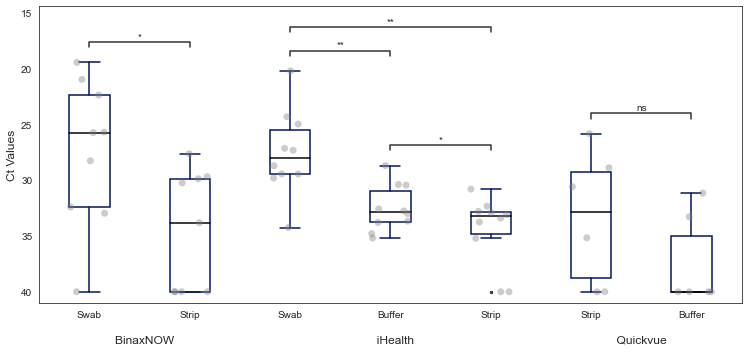

In [42]:
# update dataframe to only include matched sets for Qstr & Qtube; Bswab & Bstr (cohort2 is already matched)
df = combined.copy()
for i in range(len(combined)):
    for text in ['Q','Bs']: # check for matched Qstr & Qtube, then Bstr & Bswab sets
        if text in df.loc[i].variable:
            if sum([text in x for x in df[df.ID==df.loc[i].ID].variable]) < 2:
                df.drop([i], inplace=True)
            break # no need to check same location for other type of RDT
order = ['Bswab', 'Bstr', 'Swab','Buffer','Strip','Qstr','Qtube']
labels = ['Swab','Strip','Swab','Buffer','Strip','Strip','Buffer']

f = plt.figure(figsize=[10.5,5])
ax = sns.stripplot(data=df, x="variable", y="value", order=order, **args_stripplot)
sns.boxplot(x="variable", y="value", data=df, order=order, **args_boxplot)

ax.invert_yaxis()

pairs = [['Bstr','Bswab'],['Buffer','Strip'],['Buffer','Swab'],['Swab','Strip'],['Qstr','Qtube']]
annotator = Annotator(ax, pairs,order=order,data=df,x='variable',y='value')
annotator.set_pvalues(get_pvalues2(df,pairs,wilcoxon=True)) # do wilcoxon paired test
annotator.annotate()

lspace, rspace=[60,60]
ax.set_xlabel('\nBinaxNOW'+lspace*' '+'iHealth'+rspace*' '+'Quickvue', fontsize=12)
ax.set_xticklabels(labels)
ax.set_ylabel('Ct Values', fontsize=12)
ax.get_legend().remove()
print('Diff for iHealth strip & buffer:',
      df[df.variable=='Strip'].value.mean() - df[df.variable=='Buffer'].value.mean())

save_figure('fig/CT_allbrands_allcomponents.svg')

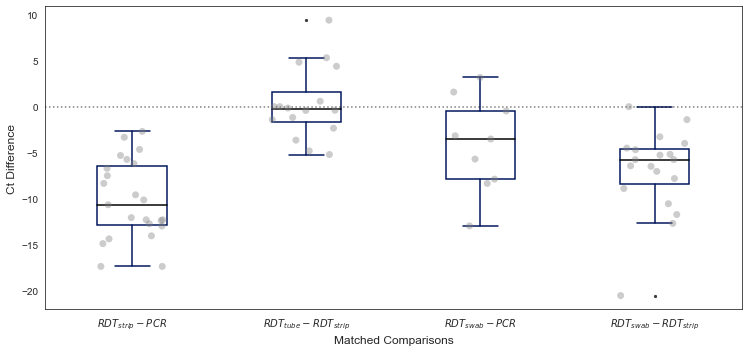

In [43]:
f = plt.figure(figsize=[10.5,5])

df = pd.melt(Ctdiffs)
order = ['PCRvRDTstr','RDTstrVtube','PCRvRDTswab','RDTstrVswab']
labels = ["$RDT_{strip} - PCR$",'$RDT_{tube} - RDT_{strip}$',\
          '$RDT_{swab} - PCR$','$RDT_{swab} - RDT_{strip}$']

ax = sns.stripplot(data=df, x="variable", y="value", order=order, **args_stripplot)
sns.boxplot(x="variable", y="value", order=order, data=df, **args_boxplot)

plt.plot(np.arange(-.5,4,.5),[0]*9,'k:',alpha=.5)

ax.set_ylabel('Ct Difference', fontsize=12)
ax.set_xticklabels(labels)
ax.set_xlabel('Matched Comparisons', fontsize=12)
ax.get_legend().remove()

save_figure('fig/CT_matched_comparisons.svg')

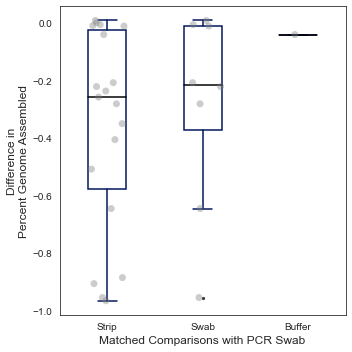

In [44]:
plt.figure(figsize=[5,5])

df = pd.melt(Genome_diffs2)
order = ['Strip','Swab','Buffer']

sns.boxplot(x="variable", y="value", order=order, data=df, **args_boxplot)
ax = sns.stripplot(data=df, x="variable", y="value", order=order, **args_stripplot)

ax.set_ylabel('Difference in\nPercent Genome Assembled', fontsize=12)
ax.set_xlabel('Matched Comparisons with PCR Swab', fontsize=12)
ax.get_legend().remove()

save_figure('fig/genomic_matched_comparisons.svg')

# samples Ct>32: 24


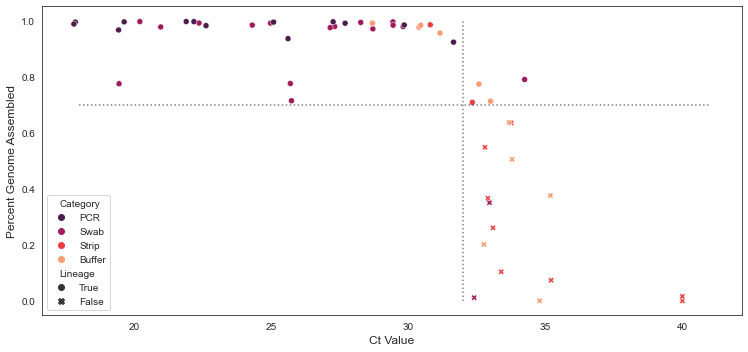

In [45]:
plt.figure(figsize=[10.5,5])

df = combined.copy().rename({'category':'Category'})
locs = np.where([len(i)==3 for i in df.ID])[0]
df.loc[locs,'Category'] = df.loc[locs,'variable']
df.loc[np.where(df.variable=='Bswab')[0],'Category'] = 'Swab'
df.loc[np.where(df.variable=='Qtube')[0],'Category'] = 'Buffer'
df.loc[np.where(df.variable=='Rnan')[0],'Category'] = 'PCR'
df['Lineage'] = ['B' in str(l) for l in combined.pango_lineage]

order = ['PCR','Swab','Strip','Buffer']
ax = sns.scatterplot(data=df, x="value", y="Percent",hue_order=order,hue='Category',palette='rocket',\
                     style='Lineage',style_order=[True,False], markers={False:'X',True:'o'})

plt.plot([32,32],[0,1],'k:', alpha=.5)
plt.plot([18,41],[.7,.7],'k:', alpha=.5)

plt.ylabel("Percent Genome Assembled", fontweight='normal', fontsize=12)
plt.xlabel("Ct Value", fontweight='normal', fontsize=12) ;
print('# samples Ct>32:',len(combined[combined.value>32].dropna(subset=['assembly_length_unambiguous'])))

save_figure('fig/genomic_CT.svg')

## Relevant stats

In [46]:
for col in Ctdiffs.columns:
    print(col)
    print('pvalue:',stats.wilcoxon(Ctdiffs[col].dropna()).pvalue)
    print('difference:',Ctdiffs[col].dropna().mean())
    print('# individuals:',len(Ctdiffs[col].dropna()),'\n')

PCRvRDTstr
pvalue: 2.384185791015625e-07
difference: -10.15989620995116
# individuals: 23 

PCRvRDTswab
pvalue: 0.0546875
difference: -4.14251557218143
# individuals: 9 

RDTstrVswab
pvalue: 0.00019643672621231134
difference: -6.948094608932407
# individuals: 19 

RDTstrVtube
pvalue: 0.9249783071207602
difference: 0.31179125763572757
# individuals: 16 



/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [47]:
print('Diff PCR v. matched RDT swabs')
print('PCR',combined[combined.variable=='Bswab'].Percent.mean()-Genome_diffs['Bswab'].dropna().mean())
print('RDT',combined[combined.variable=='Bswab'].Percent.mean())
print('Diff PCR v. matched RDT strips')
ppl = sum([len(Genome_diffs[col].dropna()) for col in ['Bstr','Qstr','inan']])
rdt = sum([len(Genome_diffs[col].dropna())*combined[combined.variable==col].Percent.mean() \
           for col in ['Bstr','Qstr','inan']]) / ppl
pcr = sum([len(Genome_diffs[col].dropna())*\
           (combined[combined.variable==col].Percent.mean()-Genome_diffs[col].dropna().mean()) \
           for col in ['Bstr','Qstr','inan']]) / ppl
print('PCR',pcr)
print('RDT',rdt)

Diff PCR v. matched RDT swabs
PCR 0.9874260107681504
RDT 0.6979901682105475
Diff PCR v. matched RDT strips
PCR 0.9802260642744877
RDT 0.5280540414005284


In [48]:
for col in Genome_diffs.columns:
    print(col)
    print('pvalue:',stats.wilcoxon(Genome_diffs[col].dropna()).pvalue)
    print('difference:',Genome_diffs[col].dropna().mean())
    print('average % for all of this category:',combined[combined.variable==col].Percent.mean())
    print('# individuals:',len(Genome_diffs[col].dropna()),'\n')

All = Genome_diffs.values.flatten()
print('All','\npvalue:',stats.wilcoxon(All, nan_policy='omit').pvalue,'\ndifference',np.nanmean(All))

Bswab
pvalue: 0.0234375
difference: -0.2894358425576029
average % for all of this category: 0.6979901682105475
# individuals: 8 

Bstr
pvalue: 0.5
difference: -0.736899307761763
average % for all of this category: 0.24407250108684747
# individuals: 2 

Qtube
pvalue: 1.0
difference: -0.03992910410326733
average % for all of this category: 0.954854028023944
# individuals: 1 

Qstr
pvalue: 0.125
difference: -0.3110724676453867
average % for all of this category: 0.6800856101394509
# individuals: 5 

inan
pvalue: 0.25
difference: -0.49751975832971057
average % for all of this category: 0.4639891203781114
# individuals: 3 

All 
pvalue: 3.814697265625e-05 
difference -0.36195453017387796


In [49]:
for col in Genome_diffs2.columns:
    print(col)
    print('pvalue:',stats.wilcoxon(Genome_diffs2[col].dropna()).pvalue)
    print('difference:',Genome_diffs2[col].dropna().mean()*LENGTH)
    print('# individuals:',len(Genome_diffs2[col].dropna()),'\n')

Strip
pvalue: 3.814697265625e-05
difference: -10823.526315789473
# individuals: 19 

Buffer
pvalue: 1.0
difference: -1194.000000000003
# individuals: 1 

Swab
pvalue: 0.0234375
difference: -8655.0
# individuals: 8 



In [50]:
#Across sample types, the ability to designate a lineage demonstrated perfect concordance with
#genome assembly of at least 70% (Fisher’s p val, Figure 4B) and a concordance of XX% with Ct < 32 
#(Fisher’s p val).

bin_assembled = np.array(combined.Percent >= .7)
bin_lineage   = np.array(['B' in str(c) for c in combined.pango_lineage])
bin_Ct32      = np.array(combined.value < 32)

# Fisher's test for genome assembly >= / < 70%; v. lineage designated or not
ftest_1 = [[sum(bin_assembled & bin_lineage), sum(bin_assembled & ~bin_lineage)],\
          [sum(~bin_assembled & bin_lineage), sum(~bin_assembled & ~bin_lineage)]]
print(stats.fisher_exact(ftest_1))
print(100*(ftest_1[0][0]+ftest_1[1][1]) / (sum(ftest_1[0])+sum(ftest_1[1])))

# Fisher's test for Ct </> 32; v. lineage designated or not
ftest_2 = [[sum(bin_Ct32 & bin_lineage), sum(bin_Ct32 & ~bin_lineage)],\
          [sum(~bin_Ct32 & bin_lineage), sum(~bin_Ct32 & ~bin_lineage)]]
print(stats.fisher_exact(ftest_2))
print(100*(ftest_2[0][0]+ftest_2[1][1]) / (sum(ftest_2[0])+sum(ftest_2[1])))


SignificanceResult(statistic=inf, pvalue=4.7082688265276965e-24)
100.0
SignificanceResult(statistic=43.714285714285715, pvalue=1.3601960406497734e-11)
86.41975308641975


# Synthetic comparisons

## Set up data tables

In [51]:
# elution time
elution_time = elution.copy()
elution_time['Type'] = elution_time['Category'].str.split(pat='(-)',expand=True).iloc[:,2]
elution_time['Time'] = elution_time['Category'].str.split(pat='(-)',expand=True).iloc[:,0]
elution_time['Ct Mean'] = pd.to_numeric(elution_time['Ct Mean'], errors='coerce').replace(np.nan,40)
elution_time.rename(columns={'Time':'variable','Ct Mean':'value'}, inplace=True)

In [52]:
# elution buffer
buffer_order = ['AVL','LB','0.5LB','VTM','TE'] # translating from samples s## to what the buffer was
buffer_df = PCR_results(buffer)
buffer_df = buffer_df[buffer_df['Sample Name'].str.startswith(('s','H2O'))].rename(columns={'CT':'value'})
buffer_df['variable'] = ['Water Control' if s=='H2O' else \
                         buffer_order[int(np.floor((int(s[1:])-1)/3))] for s in buffer_df['Sample Name']]

In [53]:
# rotating or not rotating -- some data points will be for box and whisker, and some just for scatter plots
rotation_df = PCR_results(rotation)
rot_dict = {"1hr: Rotation": rotation_df[rotation_df['Sample Name'].str.contains('HR')]['CT'].values,
            "10m: Rotation": rotation_df[rotation_df['Sample Name'].str.contains('\d+R')]['CT'].values,
            "10m: No Rotation": rotation_df[rotation_df['Sample Name'].str.contains('\d+R')]['CT'].values}
rotation_box = pd.melt(pd.DataFrame.from_dict(rot_dict, orient='index').T)
rot_dict.update({"water":rotation_df[rotation_df['Sample Name'].str.contains('H2O')].CT.values,
                 "viral seedstock":rotation_df[rotation_df['Sample Name'].str.contains('POS')].CT.values})
rotation_dot = pd.melt(pd.DataFrame.from_dict(rot_dict, orient='index').T).dropna()

In [54]:
# affect of time difference between seeding & extraction
seeding_sample = PCR_results(seeding)
seeding_sample['Type'] = seeding_sample['Sample Name'].str.split(pat='(_)',expand=True).iloc[:,0]
seeding_sample['Day'] = pd.to_numeric([t[-1] for t in seeding_sample.Type], errors='coerce')
seeding_sample['variable'] = seeding_sample['Sample Name'].str.split(pat='(_)',expand=True).iloc[:,2]
seeding_sample['variable'] = ['Strip' if n in ['1','2','3'] else n for n in seeding_sample.variable]
seeding_sample['variable'] = ['Seedstock' if n in ['pos'] else n for n in seeding_sample.variable]
seeding_sample = seeding_sample[[x is not None for x in seeding_sample.variable]]

In [55]:
#Kingfisher v. Column extractions
kff = PCR_results(KFFcomp).rename(columns={'CT':'value'})
kff[['variable','details']] = kff['Sample Name'].str.split(pat='(_)',expand=True)[[0,2]]
kff = kff[[d is not None for d in kff.details]].reset_index(drop=True)
for nonsample in ['H2O','Stock']:
    kff.loc[kff.details==nonsample,'variable'] = nonsample

## Box and whisker plots

In [56]:
sns.set_style("white")

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

24h vs. 1h: Custom statistical test, P_val:1.172e-01
1h vs. 10m: Custom statistical test, P_val:7.580e-02
24h vs. 10m: Custom statistical test, P_val:7.540e-01


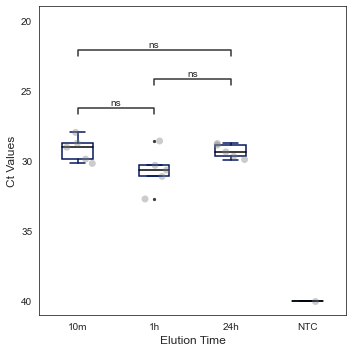

In [57]:
df = elution_time[(elution_time.Type!='tube') & (elution_time.Type!='PosCtrl')]
order = ['10m','1h','24h','NTC']

f, ax = plt.subplots(1,1,figsize=[5,5])
sns.stripplot(data=df, x="variable", y="value", order=order, **args_stripplot)
sns.boxplot(x="variable", y="value", data=df, order=order, **args_boxplot)

ax.set_ylim([41,19])
plt.yticks(np.arange(20,45,5))

pairs = [['24h','1h'],['24h','10m'],['1h','10m']]
annotator = Annotator(ax, pairs,data=df,x='variable',y='value')
annotator.set_pvalues(get_pvalues2(df,pairs))
annotator.annotate()

ax.set_xlabel('Elution Time', fontsize=12)
ax.set_ylabel('Ct Values', fontsize=12)
ax.get_legend().remove()

save_figure('fig/synthetic_elution_time.svg')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TE vs. AVL: Custom statistical test, P_val:2.752e-01
AVL vs. VTM: Custom statistical test, P_val:4.953e-02
TE vs. VTM: Custom statistical test, P_val:4.953e-02


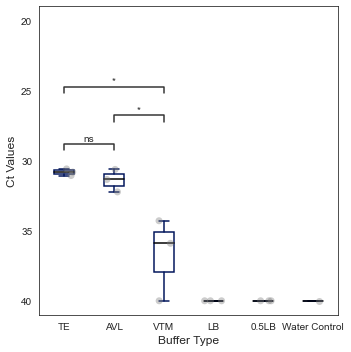

In [58]:
f = plt.figure(figsize=[5,5])

order = ['TE','AVL','VTM','LB','0.5LB','Water Control']
ax = sns.boxplot(x='variable',y='value',data=buffer_df,order=order,**args_boxplot)
sns.stripplot(data= buffer_df,order=order,x="variable", y="value",**args_stripplot)

ax.set_ylim([41,19])
plt.yticks(np.arange(20,45,5))

pairs = [['TE','AVL'],['TE','VTM'],['AVL','VTM']]
annotator = Annotator(ax, pairs,data=buffer_df,order=order,x='variable',y='value')
annotator.set_pvalues(get_pvalues2(buffer_df,pairs))
annotator.annotate()

plt.xlabel("Buffer Type", fontweight='normal', fontsize=12)
plt.ylabel("Ct Values", fontweight='normal', fontsize=12) 
plt.legend([],[], frameon=False);

save_figure('fig/synthetic_buffer_type.svg')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10m: No Rotation vs. 10m: Rotation: Custom statistical test, P_val:1.000e+00
10m: Rotation vs. 1hr: Rotation: Custom statistical test, P_val:5.127e-01
10m: No Rotation vs. 1hr: Rotation: Custom statistical test, P_val:5.127e-01


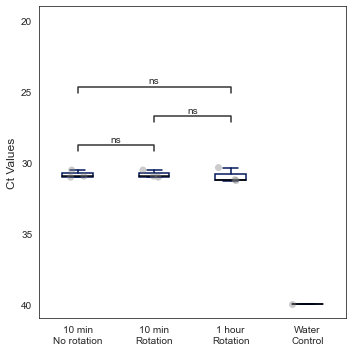

In [59]:
f = plt.figure(figsize=[5,5])
order = ['10m: No Rotation','10m: Rotation','1hr: Rotation','water']
ax = sns.boxplot(x='variable',y='value',data=rotation_dot,order=order,**args_boxplot)
sns.stripplot(data= rotation_dot,order=order,x="variable", y="value", **args_stripplot)

ax.set_ylim([41,19])
plt.yticks(np.arange(20,45,5))

pairs = [[order[0],order[1]],[order[0],order[2]],[order[1],order[2]]]
annotator = Annotator(ax, pairs, data=rotation_dot, order=order, x='variable', y='value')
annotator.set_pvalues(get_pvalues2(rotation_dot,pairs))
annotator.annotate()

ax.set_xticklabels(['10 min\nNo rotation','10 min\nRotation','1 hour\nRotation','Water\nControl'])

plt.xlabel("Rotation", fontweight='normal', fontsize=12,visible=False)
plt.ylabel("Ct Values", fontweight='normal', fontsize=12)
plt.legend([],[], frameon=False);

save_figure('fig/synthetic_rotation.svg')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ColumnExtract vs. KFFfromAVL: Custom statistical test, P_val:4.953e-02
KFFfromAVL vs. KFFwithKFFBuffer: Custom statistical test, P_val:2.752e-01
ColumnExtract vs. KFFwithKFFBuffer: Custom statistical test, P_val:4.953e-02
diff in ct: -2.040767166666665


<ipython-input-60-e4e31c633d13>:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ct_diff = (kff[kff.variable=='KFFfromAVL'].mean()+kff[kff.variable=='KFFwithKFFBuffer'].mean())/2


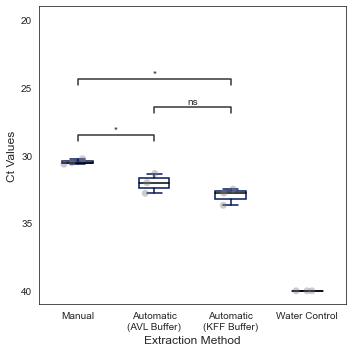

In [60]:
f = plt.figure(figsize=[5,5])
order = ['ColumnExtract','KFFfromAVL', 'KFFwithKFFBuffer','H2O']

ax = sns.stripplot(data=kff, x="variable", y="value", order=order, **args_stripplot)
sns.boxplot(x="variable", y="value", data=kff, order=order, **args_boxplot)

ax.set_ylim([41,19])
plt.yticks(np.arange(20,45,5))

pairs = [['ColumnExtract','KFFfromAVL'],['ColumnExtract','KFFwithKFFBuffer'],['KFFfromAVL','KFFwithKFFBuffer']]
annotator = Annotator(ax, pairs,data=kff,order=order,x='variable',y='value')
annotator.set_pvalues(get_pvalues2(kff,pairs))
annotator.annotate()

ax.set_xlabel('Extraction Method', fontsize=12)
ax.set_xticklabels(['Manual','Automatic\n(AVL Buffer)','Automatic\n(KFF Buffer)','Water Control'])
ax.set_ylabel('Ct Values', fontsize=12)
ax.get_legend().remove()

ct_diff = (kff[kff.variable=='KFFfromAVL'].mean()+kff[kff.variable=='KFFwithKFFBuffer'].mean())/2
ct_diff = (kff[kff.variable=='ColumnExtract'].value.mean()-ct_diff).value
print('diff in ct:',ct_diff)

save_figure('fig/synthetic_extraction_method.svg')

## Linear regression

In [61]:
sns.set_style("white")

Linregress Results for Strips:
slope = -0.06 
CI = -0.23 to 0.10 
p = 0.4463694111099027

Linregress Results for Seedstock:
slope = 0.33 
CI = 0.07 to 0.58 
p = 0.047916512267600554



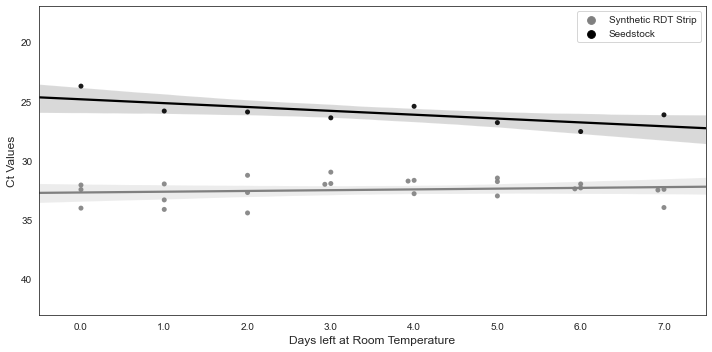

In [62]:
plt.figure(figsize=[10,5])

ax = sns.swarmplot(data=seeding_sample[seeding_sample.variable!='Ctrl'], x="Day", y="CT",**args_scatterplot_2x)
sns.regplot(x='Day', y= 'CT', data=seeding_sample[seeding_sample.variable=='Strip'],\
            scatter=False,truncate=False, line_kws = {'color':'grey'})
sns.regplot(x='Day', y= 'CT', data=seeding_sample[seeding_sample.variable=='Seedstock'],\
            scatter=False,truncate=False, line_kws = {'color':'black'})

ax.invert_yaxis()

plt.xlabel("Days left at Room Temperature", fontweight='normal', fontsize=12)
plt.ylabel("Ct Values", fontweight='normal', fontsize=12) 

ax.set_ylim([43,17])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=['Synthetic RDT Strip','Seedstock']);

#stats
slope95CI(seeding_sample[seeding_sample.variable=='Strip']['Day'],\
          seeding_sample[seeding_sample.variable=='Strip']['CT'],'Strips')
slope95CI(seeding_sample[seeding_sample.variable=='Seedstock']['Day'],\
          seeding_sample[seeding_sample.variable=='Seedstock']['CT'],'Seedstock')

save_figure('fig/synthetic_days_at_room_temp.svg')